<a href="https://colab.research.google.com/github/sahishnu/nyu-ml-quora/blob/main/quora_insincere_questions_Notebooks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports & Data

In [ ]:
!pip install kaggle # we are using kaggles api to download the dataset

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c quora-insincere-questions-classification

100% 5.95G/5.96G [02:16<00:00, 30.2MB/s]
100% 5.96G/5.96G [02:16<00:00, 47.0MB/s]
100% 4.09M/4.09M [00:00<00:00, 10.1MB/s]

 62% 34.0M/54.9M [00:01<00:02, 10.8MB/s]
100% 54.9M/54.9M [00:02<00:00, 27.8MB/s]
 32% 5.00M/15.8M [00:01<00:02, 3.86MB/s]
100% 15.8M/15.8M [00:01<00:00, 11.7MB/s]


In [ ]:
!unzip embeddings.zip

Archive:  embeddings.zip
   creating: GoogleNews-vectors-negative300/
   creating: glove.840B.300d/
   creating: paragram_300_sl999/
   creating: wiki-news-300d-1M/
  inflating: glove.840B.300d/glove.840B.300d.txt  
  inflating: GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin  
  inflating: wiki-news-300d-1M/wiki-news-300d-1M.vec  
  inflating: paragram_300_sl999/README.txt  
  inflating: paragram_300_sl999/paragram_300_sl999.txt  


In [ ]:
!unzip train.csv.zip
!unzip test.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                


In [ ]:
import os
import numpy as np
import pandas as pd
import time
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D
from tensorflow.compat.v1.keras.layers import CuDNNGRU
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

import lightgbm as lgb

from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

import nltk
from nltk.corpus import stopwords
import string

from scipy.sparse import hstack

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
import nltk
# In computing, stop words are words which are filtered out before or after processing of natural language data (text).
# Though "stop words" usually refers to the most common words in a language, there is no single universal list of stop
# words used by all natural language processing tools, and indeed not all tools even use such a list.
# Some tools specifically avoid removing these stop words to support phrase search.
# https://en.wikipedia.org/wiki/Stop_word
nltk.download('stopwords')
eng_stopwords = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# reference to training data
# we will split our training data into test & training
# this is because we dont have the real values of the test set
train = pd.read_csv('train.csv')

In [ ]:
train.head() # logging the first 5 rows of the dataframe

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [ ]:
train.shape # total size of the dataframe

(1306122, 3)

In [ ]:
train_target = train['target'].values
# get a list of the unique target values from the training data  set
np.unique(train_target)

array([0, 1])

In [ ]:
train_target.mean()
# the mean of the target values can tell us how skewed the target values are
# a very low mean can indicate that there are very few insincere questions

0.06187017751787352

#Feature Engineering [Regression]

Here we will come up with our own set of features from the data set and attempt to create a regression model. This can help us analyze and identify any patterns at a very basic level.

Some features for any given question text could be:
1. Number of words
2. Number of unique words
3. Number of characters
4. Number of stopwords
5. Number of punctuations
6. Mean length of words

In [ ]:
## Number of words in the Question text ##
train["num_words"] = train["question_text"].apply(lambda x: len(str(x).split()))


## Number of unique words in the Question text ##
train["num_unique_words"] = train["question_text"].apply(lambda x: len(set(str(x).split())))


## Number of characters in the Question text ##
train["num_chars"] = train["question_text"].apply(lambda x: len(str(x)))


## Number of stopwords in the Question text ##
train["num_stopwords"] = train["question_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

## Number of punctuations in the Question text ##
train["num_punctuations"] =train['question_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )


## Number of title case words in the Question text ##
train["num_words_upper"] = train["question_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))


## Number of title case words in the Question text ##
train["num_words_title"] = train["question_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))


## Average length of the words in the Question text ##
train["mean_word_len"] = train["question_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))


In [ ]:
train.head() # look at the updated feature columns in the data set

,qid,question_text,target,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,13,13,72,7,1,0,2,4.615385
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,16,15,81,9,2,0,1,4.125000
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,10,8,67,3,2,0,2,5.800000
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,9,9,57,3,1,0,4,5.444444
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,15,15,77,8,1,2,3,4.200000


## Graphing the features

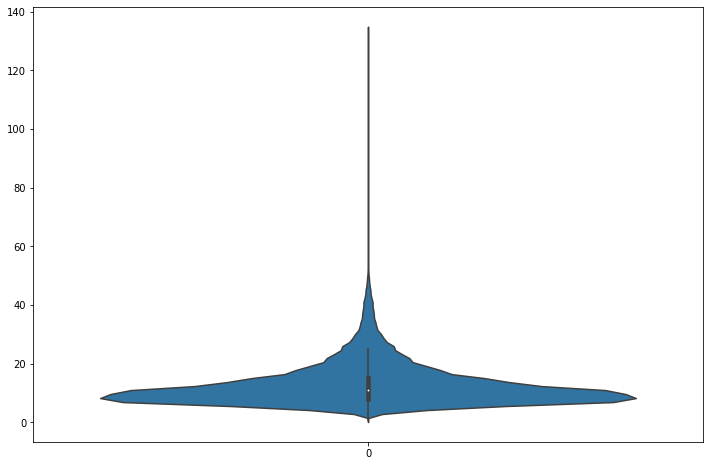

In [ ]:
# Number of words
plt.figure(figsize=(12,8))
sns.violinplot(data=train['num_words'])
plt.show()

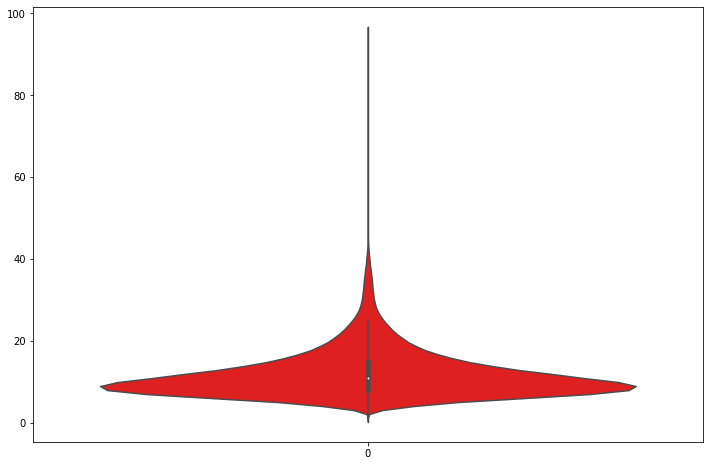

In [ ]:
# Number of unique words
plt.figure(figsize=(12,8))
sns.violinplot(data=train['num_unique_words'], color = 'red')
plt.show()

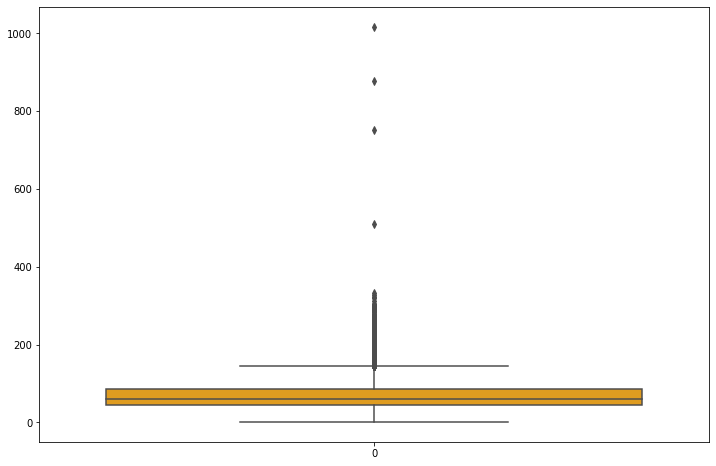

In [ ]:
# Number of chars
plt.figure(figsize=(12,8))
sns.boxplot(data=train['num_chars'], color='orange')
plt.show()

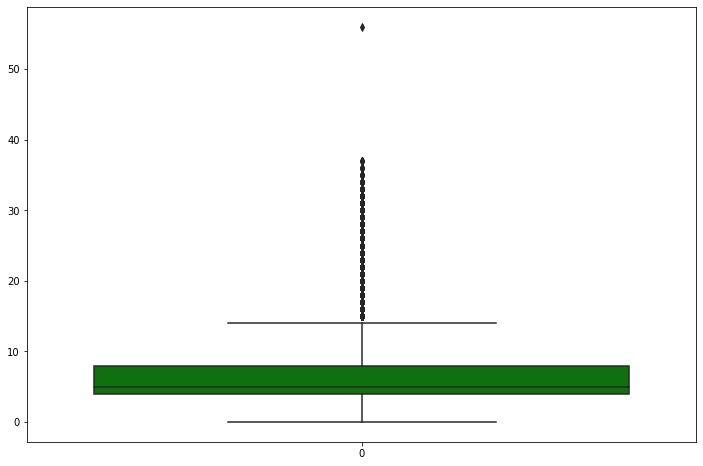

In [ ]:
# Number of stopwords
plt.figure(figsize=(12,8))
sns.boxplot(data=train['num_stopwords'], color='green')
plt.show()

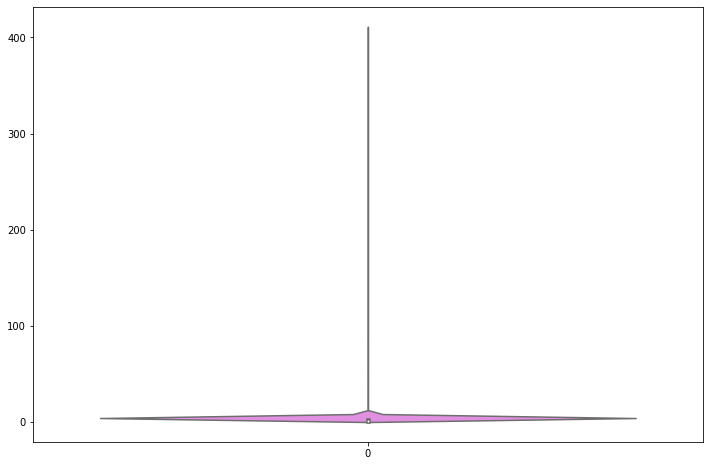

In [ ]:
# Number of punctuations
plt.figure(figsize=(12,8))
sns.violinplot(data=train['num_punctuations'], color='violet')
plt.show()

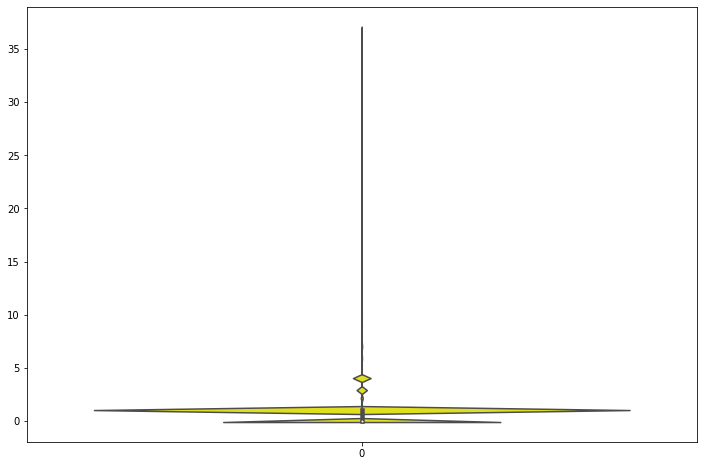

In [ ]:
# Number of words with upper case
plt.figure(figsize=(12,8))
sns.violinplot(data=train['num_words_upper'], color='yellow')
plt.show()

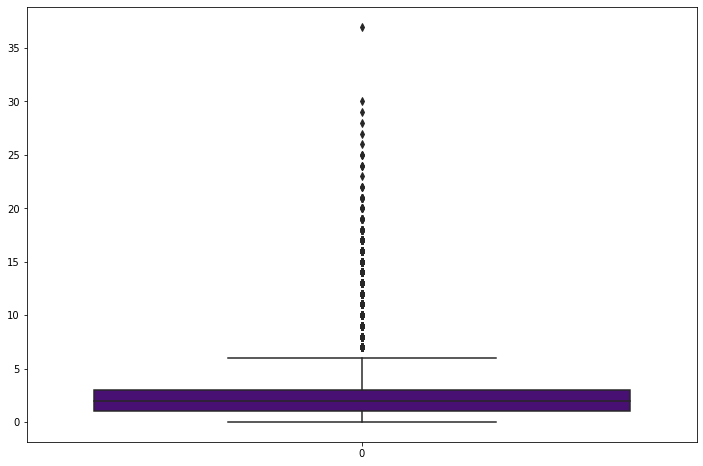

In [ ]:
plt.figure(figsize=(12,8))
sns.boxplot(data=train['num_words_title'], color='indigo')
plt.show()

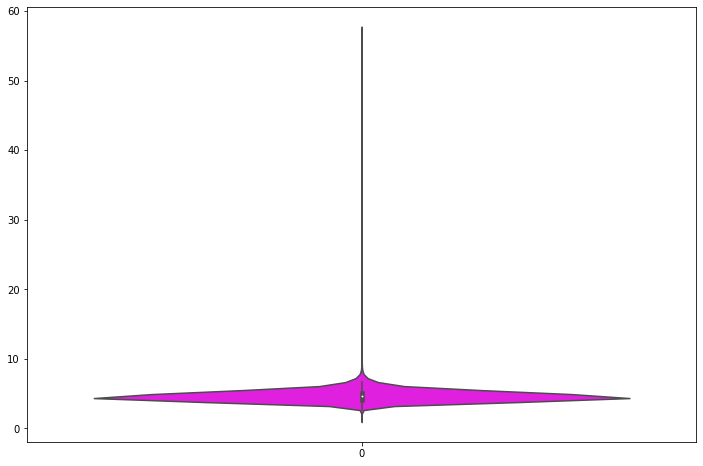

In [ ]:
# Mean length of words
plt.figure(figsize=(12,8))
sns.violinplot(data=train['mean_word_len'], color='magenta')
plt.show()

# Training baseline methods

We will explore 2 methods

1. Bag of words
2. TFIDF

In [ ]:
eng_features = ['num_words', 'num_unique_words', 'num_chars', 
                'num_stopwords', 'num_punctuations', 'num_words_upper', 
                'num_words_title', 'mean_word_len']

### Bag of words method

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer 

bow = CountVectorizer()

In [ ]:
# Bag of words method [Baseline 1]
# Here the text input is converted to a set of normalized frequency values
kf = KFold(n_splits=5, shuffle=True, random_state=43)
test_pred_cv = 0
oof_pred_cv = np.zeros([train.shape[0],])


for i, (train_index, val_index) in tqdm(enumerate(kf.split(train))):
    x_train, x_val = train.loc[train_index]['question_text'].values, train.loc[val_index]['question_text'].values
    y_train, y_val = train_target[train_index], train_target[val_index]
   
    
    bow = CountVectorizer()
    x_train = bow.fit_transform(x_train)
    x_val = bow.transform(x_val)
    

    classifier = LogisticRegression(penalty = "l1", C = 1.25, class_weight = "balanced", solver='liblinear')
    
    classifier.fit(x_train, y_train)
    val_preds = classifier.predict_proba(x_val)[:,1]
   
    
    oof_pred_cv[val_index] = val_preds

5it [04:12, 50.41s/it]


In [ ]:
pred_train = (oof_pred_cv > 0.75).astype(np.int)
f1_score(train_target, pred_train)

0.6052083226409091

### TFIDF (Term Frequency Inverse Document Frequency) Method

In [ ]:
# Term frequency inverse document frequency (TFIDF) [Baseline 2]
train_text = train['question_text']
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=5000)

train_word_features = word_vectorizer.fit_transform(train_text)

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=43)
test_pred_tf = 0
oof_pred_tf = np.zeros([train.shape[0],])

for i, (train_index, val_index) in tqdm(enumerate(kf.split(train))):
    x_train, x_val = train_word_features[train_index,:], train_word_features[val_index,:]
    y_train, y_val = train_target[train_index], train_target[val_index]
    classifier = LogisticRegression(class_weight = "balanced", C=0.5, solver='liblinear')
    classifier.fit(x_train, y_train)
    val_preds = classifier.predict_proba(x_val)[:,1]
    
    
    oof_pred_tf[val_index] = val_preds

5it [00:40,  8.03s/it]


In [ ]:
pred_train = (oof_pred_tf > 0.8).astype(np.int)
f1_score(train_target, pred_train)

0.5660070393330711

In [ ]:
import lightgbm as lgb

def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True

params = {'learning_rate': 0.05,
          'application': 'regression',
          'max_depth': 9,
          'num_leaves': 100,
          'verbosity': -1,
          'metric': 'rmse',
          'data_random_seed': 3,
          'bagging_fraction': 0.8,
          'feature_fraction': 0.4,
          'nthread': 16,
          'lambda_l1': 1,
          'lambda_l2': 1,
          'num_rounds': 2700,
          'verbose_eval': 100}


kf = KFold(n_splits=5, shuffle=True, random_state=43)
test_pred_lgb = 0
oof_pred_lgb = np.zeros([train.shape[0],])

for i, (train_index, val_index) in tqdm(enumerate(kf.split(train))):
    x_train, x_val = train_word_features[train_index,:], train_word_features[val_index,:]
    y_train, y_val = train_target[train_index], train_target[val_index]
    
    d_train = lgb.Dataset(x_train, label=y_train)
    d_valid = lgb.Dataset(x_val, label=y_val)

    num_rounds = 2500
    model = lgb.train(params,
                  train_set=d_train,
                  num_boost_round=num_rounds,
                  valid_sets=[d_train, d_valid],
                  valid_names=['train', 'val'],
                  verbose_eval=0)
    
    val_preds = model.predict(x_val)
    
    oof_pred_lgb[val_index] = val_preds

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
5it [1:02:15, 747.06s/it]


In [ ]:
train.head()

,qid,question_text,target,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,13,13,72,7,1,0,2,4.615385
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,16,15,81,9,2,0,1,4.125000
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,10,8,67,3,2,0,2,5.800000
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,9,9,57,3,1,0,4,5.444444
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,15,15,77,8,1,2,3,4.200000


#Comparison of Different Word Embeddings

In [ ]:
train = train[['qid', 'question_text', 'target']]

In [ ]:
train_df, val_df = train_test_split(train, test_size=0.1, random_state=3690)


embed_size = 300 # Dimensions of each word vector
max_features = 50000 # Number of words to be used as vocab
maxlen = 100 # max number of words in a question to use

## fill up the missing values
train_X = train_df["question_text"].fillna("_na_").values
val_X = val_df["question_text"].fillna("_na_").values

In [ ]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)

In [ ]:
#Padding of the sentences to make it equal length 
train_X = pad_sequences(train_X, maxlen=maxlen)
val_X = pad_sequences(val_X, maxlen=maxlen)

In [ ]:
train_y = train_df['target'].values
val_y = val_df['target'].values

In [ ]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size)(inp)
x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 128)          140544    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                2064      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17    

In [ ]:
model.fit(train_X, train_y, batch_size=512, epochs=10, validation_data=(val_X, val_y))


Epoch 1/10
2296/2296 [==============================] - 708s 295ms/step - loss: 0.1500 - accuracy: 0.9474 - val_loss: 0.1087 - val_accuracy: 0.9569
Epoch 2/10
2296/2296 [==============================] - 662s 288ms/step - loss: 0.0962 - accuracy: 0.9617 - val_loss: 0.1082 - val_accuracy: 0.9568
Epoch 3/10
2296/2296 [==============================] - 657s 286ms/step - loss: 0.0802 - accuracy: 0.9680 - val_loss: 0.1145 - val_accuracy: 0.9552
Epoch 4/10
2296/2296 [==============================] - 663s 289ms/step - loss: 0.0635 - accuracy: 0.9748 - val_loss: 0.1334 - val_accuracy: 0.9547
Epoch 5/10
2296/2296 [==============================] - 664s 289ms/step - loss: 0.0478 - accuracy: 0.9809 - val_loss: 0.1522 - val_accuracy: 0.9532
Epoch 6/10
2296/2296 [==============================] - 663s 289ms/step - loss: 0.0359 - accuracy: 0.9854 - val_loss: 0.1861 - val_accuracy: 0.9504
Epoch 7/10
2296/2296 [==============================] - 654s 285ms/step - loss: 0.0270 - accuracy: 0.9890 - val_

In [ ]:
pred_noemb_val_y = model.predict([val_X], batch_size=1024, verbose=1)
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_y, (pred_noemb_val_y>thresh).astype(int))))

128/128 [==============================] - 10s 77ms/step
F1 score at threshold 0.1 is 0.5736898395721926
F1 score at threshold 0.11 is 0.5751669179409864
F1 score at threshold 0.12 is 0.574867179876396
F1 score at threshold 0.13 is 0.575119930222416
F1 score at threshold 0.14 is 0.5760017540974621
F1 score at threshold 0.15 is 0.5769400352733687
F1 score at threshold 0.16 is 0.5772772661710863
F1 score at threshold 0.17 is 0.5783428125348501
F1 score at threshold 0.18 is 0.5781188728922748
F1 score at threshold 0.19 is 0.5785505289218996
F1 score at threshold 0.2 is 0.5793906506133063
F1 score at threshold 0.21 is 0.5793713831839328
F1 score at threshold 0.22 is 0.579855377782839
F1 score at threshold 0.23 is 0.5794168096054888
F1 score at threshold 0.24 is 0.5790983136400137
F1 score at threshold 0.25 is 0.5781384907615266
F1 score at threshold 0.26 is 0.5779472073008723
F1 score at threshold 0.27 is 0.5779529384490554
F1 score at threshold 0.28 is 0.5778578904523781
F1 score at thres

In [ ]:
EMBEDDING_FILE = 'glove.840B.300d/glove.840B.300d.txt'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
        
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 128)          140544    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17  

In [ ]:
model.fit(train_X, train_y, batch_size=512, epochs=3, validation_data=(val_X, val_y))

Epoch 1/3
2296/2296 [==============================] - 711s 309ms/step - loss: 0.1415 - accuracy: 0.9473 - val_loss: 0.1025 - val_accuracy: 0.9591
Epoch 2/3
2296/2296 [==============================] - 690s 301ms/step - loss: 0.0934 - accuracy: 0.9635 - val_loss: 0.1022 - val_accuracy: 0.9589
Epoch 3/3
2296/2296 [==============================] - 688s 300ms/step - loss: 0.0787 - accuracy: 0.9688 - val_loss: 0.1071 - val_accuracy: 0.9585


In [ ]:
pred_glove_val_y = model.predict([val_X], batch_size=1024, verbose=1)
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_y, (pred_glove_val_y>thresh).astype(int))))


128/128 [==============================] - 6s 45ms/step
F1 score at threshold 0.1 is 0.6250573236723838
F1 score at threshold 0.11 is 0.6298970512880234
F1 score at threshold 0.12 is 0.634603550295858
F1 score at threshold 0.13 is 0.6384696722099394
F1 score at threshold 0.14 is 0.6407643933115585
F1 score at threshold 0.15 is 0.6448011854778958
F1 score at threshold 0.16 is 0.6480072100941318
F1 score at threshold 0.17 is 0.6505621391674262
F1 score at threshold 0.18 is 0.6529086439983613
F1 score at threshold 0.19 is 0.654417473215672
F1 score at threshold 0.2 is 0.6559055529436347
F1 score at threshold 0.21 is 0.6577683988393563
F1 score at threshold 0.22 is 0.6593465167101967
F1 score at threshold 0.23 is 0.6610342786417694
F1 score at threshold 0.24 is 0.6615919965202262
F1 score at threshold 0.25 is 0.6634852723383249
F1 score at threshold 0.26 is 0.6647491564798936
F1 score at threshold 0.27 is 0.6654019974334654
F1 score at threshold 0.28 is 0.6655046387405116
F1 score at thres

# BI-GRU method


In [ ]:
!pip install kaggle # we are using kaggles api to download the dataset
from google.colab import files
files.upload()

!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c quora-insincere-questions-classification

!unzip embeddings.zip

!unzip train.csv.zip
!unzip test.csv.zip

Saving kaggle.json to kaggle.json
100% 5.95G/5.96G [02:09<00:00, 42.7MB/s]
100% 5.96G/5.96G [02:09<00:00, 49.3MB/s]
 75% 41.0M/54.9M [00:01<00:08, 1.71MB/s]
100% 54.9M/54.9M [00:01<00:00, 34.5MB/s]
100% 4.09M/4.09M [00:00<00:00, 30.4MB/s]

 57% 9.00M/15.8M [00:00<00:00, 30.1MB/s]
100% 15.8M/15.8M [00:00<00:00, 40.0MB/s]
Archive:  embeddings.zip
   creating: GoogleNews-vectors-negative300/
   creating: glove.840B.300d/
   creating: paragram_300_sl999/
   creating: wiki-news-300d-1M/
  inflating: glove.840B.300d/glove.840B.300d.txt  
  inflating: GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin  
  inflating: wiki-news-300d-1M/wiki-news-300d-1M.vec  
  inflating: paragram_300_sl999/README.txt  
  inflating: paragram_300_sl999/paragram_300_sl999.txt  
Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                


In [ ]:
import os
import numpy as np
import pandas as pd
import time
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D
from tensorflow.compat.v1.keras.layers import CuDNNGRU, CuDNNLSTM
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
import re

# Imports for visualisations
from IPython.display import HTML as html_print
from IPython.display import display
import lightgbm as lgb

from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

import nltk
from nltk.corpus import stopwords
import string

from scipy.sparse import hstack

import matplotlib.pyplot as plt
import seaborn as sns


ParserError: ignored

In [ ]:
train = train[['qid', 'question_text', 'target']]
train_df, val_df = train_test_split(train, test_size=0.1, random_state=3690)
embed_size = 300 # Dimensions of each word vector
max_features = 50000 # Number of words to be used as vocab
maxlen = 100 # max number of words in a question to use

## fill up the missing values
train_X = train_df["question_text"].fillna("_na_").values
val_X = val_df["question_text"].fillna("_na_").values

## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)
#Padding of the sentences to make it equal length 
train_X = pad_sequences(train_X, maxlen=maxlen)
val_X = pad_sequences(val_X, maxlen=maxlen)
train_y = train_df['target'].values
val_y = val_df['target'].values

In [ ]:
EMBEDDING_FILE = 'glove.840B.300d/glove.840B.300d.txt'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
        

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


In [ ]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 128)          187392    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                2064      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17    

In [ ]:
model.fit(train_X, train_y, batch_size=512, epochs=10, validation_data=(val_X, val_y))


Epoch 1/10
2296/2296 [==============================] - 532s 218ms/step - loss: 0.1308 - accuracy: 0.9503 - val_loss: 0.1025 - val_accuracy: 0.9595
Epoch 2/10
2296/2296 [==============================] - 496s 216ms/step - loss: 0.0933 - accuracy: 0.9630 - val_loss: 0.1016 - val_accuracy: 0.9594
Epoch 3/10
2296/2296 [==============================] - 493s 215ms/step - loss: 0.0803 - accuracy: 0.9683 - val_loss: 0.1074 - val_accuracy: 0.9598
Epoch 4/10
2296/2296 [==============================] - 491s 214ms/step - loss: 0.0667 - accuracy: 0.9740 - val_loss: 0.1173 - val_accuracy: 0.9578
Epoch 5/10
2296/2296 [==============================] - 490s 213ms/step - loss: 0.0525 - accuracy: 0.9796 - val_loss: 0.1309 - val_accuracy: 0.9559
Epoch 6/10
2296/2296 [==============================] - 489s 213ms/step - loss: 0.0401 - accuracy: 0.9845 - val_loss: 0.1576 - val_accuracy: 0.9541
Epoch 7/10
2296/2296 [==============================] - 490s 213ms/step - loss: 0.0304 - accuracy: 0.9880 - val_

In [ ]:
pred_noemb_val_y = model.predict([val_X], batch_size=1024, verbose=1)
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_y, (pred_noemb_val_y>thresh).astype(int))))

128/128 [==============================] - 6s 45ms/step
F1 score at threshold 0.1 is 0.6163465832961144
F1 score at threshold 0.11 is 0.616188282873673
F1 score at threshold 0.12 is 0.6168361581920904
F1 score at threshold 0.13 is 0.6159790885327878
F1 score at threshold 0.14 is 0.6161748758632498
F1 score at threshold 0.15 is 0.6157635467980296
F1 score at threshold 0.16 is 0.6153669197147459
F1 score at threshold 0.17 is 0.6156509695290858
F1 score at threshold 0.18 is 0.6152419588525065
F1 score at threshold 0.19 is 0.6152414194299012
F1 score at threshold 0.2 is 0.614809623919645
F1 score at threshold 0.21 is 0.6146278620366575
F1 score at threshold 0.22 is 0.6148418205339292
F1 score at threshold 0.23 is 0.6145857918338447
F1 score at threshold 0.24 is 0.6148928613709009
F1 score at threshold 0.25 is 0.6145901347420906
F1 score at threshold 0.26 is 0.6140288198166011
F1 score at threshold 0.27 is 0.6143291773548887
F1 score at threshold 0.28 is 0.6141421392677674
F1 score at thres

In [ ]:

import gc   ### gc – Garbage Collector. Purpose: Manages memory used by Python objects. 
gc.collect() 

3172

In [ ]:

embed_size = 300
embedding_path = "glove.840B.300d/glove.840B.300d.txt"
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')

embedding_index = dict(get_coefs(*o.split(" ")) for o in open(embedding_path, encoding='utf-8', errors='ignore'))

all_embs = np.stack(embedding_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))

embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words + 1, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

embedding_path = "paragram_300_sl999/paragram_300_sl999.txt"
embedding_index = dict(get_coefs(*o.split(" ")) for o in open(embedding_path, encoding='utf-8', errors='ignore') if len(o)>100)

all_embs = np.stack(embedding_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))

embedding_matrix1 = np.random.normal(emb_mean, emb_std, (nb_words + 1, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None: embedding_matrix1[i] = embedding_vector  

EMBEDDING_FILE = 'wiki-news-300d-1M/wiki-news-300d-1M.vec'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if len(o)>100)

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
#embed_size = all_embs.shape[1]


nb_words = min(max_features, len(word_index))

embedding_matrix2 = np.random.normal(emb_mean, emb_std, (nb_words + 1, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix2[i] = embedding_vector

embedding_matrix_final = np.mean([embedding_matrix, embedding_matrix1, embedding_matrix2], axis=0)
del embedding_matrix1, embedding_matrix2
import gc   ### gc – Garbage Collector. Purpose: Manages memory used by Python objects. 
gc.collect()  ### The garbage collection can be invoked manually


def sigmoid(x):
    return 1 / (1 + np.exp(-x))

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


In [ ]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

filepath="model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 128)          140544    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                2064      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17    

In [ ]:
model.fit(train_X, train_y, batch_size=512, epochs=3, validation_data=(val_X, val_y), callbacks=callbacks_list)


Epoch 1/3
2296/2296 [==============================] - 522s 214ms/step - loss: 0.1265 - accuracy: 0.9524 - val_loss: 0.1020 - val_accuracy: 0.9592

Epoch 00001: loss improved from inf to 0.11134, saving model to model.hdf5
Epoch 2/3
2296/2296 [==============================] - 491s 214ms/step - loss: 0.0923 - accuracy: 0.9630 - val_loss: 0.1014 - val_accuracy: 0.9594

Epoch 00002: loss improved from 0.11134 to 0.09230, saving model to model.hdf5
Epoch 3/3
2296/2296 [==============================] - 489s 213ms/step - loss: 0.0770 - accuracy: 0.9696 - val_loss: 0.1077 - val_accuracy: 0.9587

Epoch 00003: loss improved from 0.09230 to 0.07866, saving model to model.hdf5


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pred_noemb_val_y = model.predict([val_X], batch_size=1024, verbose=1)
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_y, (pred_noemb_val_y>thresh).astype(int))))

128/128 [==============================] - 6s 45ms/step
F1 score at threshold 0.1 is 0.6109401108081963
F1 score at threshold 0.11 is 0.6171060287338317
F1 score at threshold 0.12 is 0.6226646665757534
F1 score at threshold 0.13 is 0.626991089154624
F1 score at threshold 0.14 is 0.6317316240116034
F1 score at threshold 0.15 is 0.6350814085573646
F1 score at threshold 0.16 is 0.6384305448963928
F1 score at threshold 0.17 is 0.6400969696969696
F1 score at threshold 0.18 is 0.6429692096489508
F1 score at threshold 0.19 is 0.6449347051840126
F1 score at threshold 0.2 is 0.648051948051948
F1 score at threshold 0.21 is 0.6502925156344563
F1 score at threshold 0.22 is 0.6525812035434273
F1 score at threshold 0.23 is 0.6542766197761577
F1 score at threshold 0.24 is 0.6558700263879547
F1 score at threshold 0.25 is 0.6571682062522833
F1 score at threshold 0.26 is 0.658289079341711
F1 score at threshold 0.27 is 0.6596420629037383
F1 score at threshold 0.28 is 0.6609336609336609
F1 score at thresh

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# get html element
def cstr(s, color='black'):
	if s == ' ':
		return "<text style=color:#000;padding-left:10px;background-color:{}> </text>".format(color, s)
	else:
		return "<text style=color:#000;background-color:{}>{} </text>".format(color, s)
	
# print html
def print_color(t):
	display(html_print(''.join([cstr(ti, color=ci) for ti,ci in t])))

# get appropriate color for value
def get_clr(value):
	colors = ['#85c2e1', '#89c4e2', '#95cae5', '#99cce6', '#a1d0e8'
		'#b2d9ec', '#baddee', '#c2e1f0', '#eff7fb', '#f9e8e8',
		'#f9e8e8', '#f9d4d4', '#f9bdbd', '#f8a8a8', '#f68f8f',
		'#f47676', '#f45f5f', '#f34343', '#f33b3b', '#f42e2e']
	value = int((value * 100) / 5)
	return colors[value]

def visualize(output_values, result_list, cell_no):
  print("\nCell Number:", cell_no, "\n")
  text_colours = []
  for i in range(len(output_values)):
    text = (result_list[i], get_clr(output_values[i][cell_no]))
    text_colours.append(text)
  print_color(text_colours)

# Get Predictions from random sequence
def get_predictions(data):
  start = np.random.randint(0, len(data)-1)
  pattern = data[start]
  result_list, output_values = [], []
  print("Seed:")
  print("\"" + ''.join([int_to_char[value] for value in pattern]) + "\"")
  print("\nGenerated:")

  for i in range(1000):
    # Reshaping input array for predicting next character
    x = np.reshape(pattern, (1, len(pattern), 1))
    x = x / float(n_vocab)

    # Prediction
    prediction = model.predict(x, verbose=0)

    # LSTM Activations
    output = attn_func([x])[0][0]
    output = sigmoid(output)
    output_values.append(output)

    # Predicted Character
    index = np.argmax(prediction)
    result = int_to_char[index]

    # Preparing input for next character
    seq_in = [int_to_char[value] for value in pattern]
    pattern.append(index)
    pattern = pattern[1:len(pattern)]

    # Saving generated characters
    result_list.append(result)
  return output_values, result_list




In [ ]:
print(val_X)

[[    0     0     0 ...     6   231   278]
 [    0     0     0 ...  1702    22   104]
 [    0     0     0 ...     1   141   154]
 ...
 [    0     0     0 ...  1543     5   181]
 [    0     0     0 ...  1713   456   123]
 [    0     0     0 ... 24003     4 27090]]


In [ ]:
import keras.backend as K
from keras.models import load_model

model = load_model("model.hdf5")
partial_model = Model(model.inputs, model.layers[3].output)
print(partial_model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 128)          140544    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
Total params: 15,140,544
Trainable params: 15,140,544
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
## fill up the missing values
train_X = train_df["question_text"].fillna("_na_").values
val_X = val_df["question_text"].fillna("_na_").values

## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)
#Padding of the sentences to make it equal length 
train_X = pad_sequences(train_X, maxlen=maxlen)
val_X = pad_sequences(val_X, maxlen=maxlen)
print(val_X)

[[    0     0     0 ...     6   231   278]
 [    0     0     0 ...  1702    22   104]
 [    0     0     0 ...     1   141   154]
 ...
 [    0     0     0 ...  1543     5   181]
 [    0     0     0 ...  1713   456   123]
 [    0     0     0 ... 24003     4 27090]]


In [ ]:
test = val_df["question_text"].fillna("_na_").values[85:86]
print(test)
print(val_X[85:86])

['Why did Bill Gates name his company after his dick?']
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0   16   48 1145 4311  191   90  167   59
    90 3161]]


In [ ]:
output_test = partial_model([val_X[85:86]], training=False)


In [ ]:
class Vocabulary(object):
    # credits : Shankar G see https://www.kaggle.com/kaosmonkey/visualize-sincere-vs-insincere-words
    
    def __init__(self):
        self.vocab = {}
        self.STOPWORDS = set()
        self.STOPWORDS = set(stopwords.words('english'))
        
    def build_vocab(self, lines):
        for line in lines:
            for word in line.split(' '):
                word = word.lower()
                if (word in self.STOPWORDS):
                    continue
                if (word not in self.vocab):
                    self.vocab[word] = 0
                self.vocab[word] +=1 
    
    def generate_ngrams(text, n_gram=1):
        """arg: text, n_gram"""
        token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
        ngrams = zip(*[token[i:] for i in range(n_gram)])
        return [" ".join(ngram) for ngram in ngrams]
    
    def horizontal_bar_chart(df, color):
        trace = go.Bar(
            y=df["word"].values[::-1],
            x=df["wordcount"].values[::-1],
            showlegend=False,
            orientation = 'h',
            marker=dict(
            color=color,
            ),
        )
        return trace

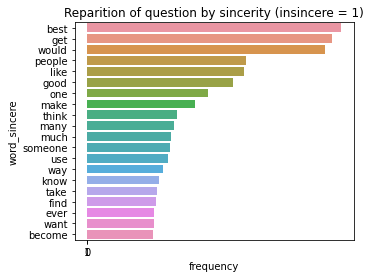

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

nltk.download('stopwords')
train = pd.read_csv('train.csv')
train = train[['qid', 'question_text', 'target']]
train_df, val_df = train_test_split(train, test_size=0.1, random_state=3690)

sincere_vocab = Vocabulary()
sincere_vocab.build_vocab(train_df[train_df['target'] == 0]['question_text'])
sincere_vocabulary = sorted(sincere_vocab.vocab.items(), reverse=True, key=lambda kv: kv[1])
    
df_sincere_vocab = pd.DataFrame(sincere_vocabulary, columns=['word_sincere', 'frequency'])
sns.barplot(y='word_sincere', x='frequency', data=df_sincere_vocab[:20])

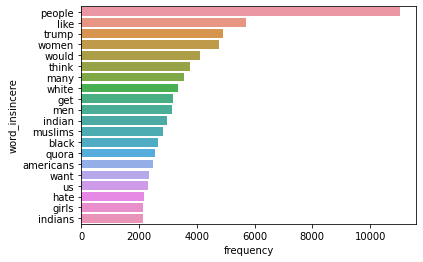

In [ ]:
insincere_vocab = Vocabulary()
insincere_vocab.build_vocab(train[train['target'] == 1]['question_text'])
insincere_vocabulary = sorted(insincere_vocab.vocab.items(), reverse=True, key=lambda kv: kv[1])

df_insincere_vocab = pd.DataFrame(insincere_vocabulary, columns=['word_insincere', 'frequency'])
sns.barplot(y='word_insincere', x='frequency', data=df_insincere_vocab[:20])

In [ ]:
plt.figure(figsize=(5, 4))
sns.countplot(x='target', data=train)
plt.title('Class distribution (sincere = 0, insincere = 1)');

NameError: ignored

In [ ]:
test_df_0 = train_df[train_df['target'] == 0]['question_text'].fillna("_na_").values
test_df_1 = train_df[train_df['target'] == 1]['question_text'].fillna("_na_").values

## Tokenize the sentences
max_features = 50000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(test_df_0))
train_X = tokenizer.texts_to_sequences(test_df_0)
#Padding of the sentences to make it equal length 
train_X = pad_sequences(train_X, maxlen=maxlen)
train_y = train_df['target'].values


NameError: ignored